lien pas mal sur eigenmaps: https://www.youtube.com/watch?v=BgMFBqrtCwo

# [NTDS'18] Project
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: 3
* Students: Baptiste Hériard-Dubreuil, Jean-Baptiste Membrado, Guilhem Noiraud, Amaury Véron
* Dataset: Flight routes

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers
import networkx as nx
from sklearn.cluster import KMeans
import folium

### Add geographic coordinates to our features

*Dataset of routes*

In [3]:
features = pd.read_csv("routes.dat", names = ["airline",
                                              "airline_id",
                                              "source_airport",
                                              "source_airport_id",
                                              "destination_airport",
                                              "destination_airport_id",
                                              "codeshare",
                                              "stops",
                                              "equipment"])
features.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


*Get nodes and edges*

In [4]:
source_airports = features[["source_airport_id", "source_airport"]]
source_airports.columns = ["airport_id", "airport"]

destination_airports =  features[["destination_airport_id", "destination_airport"]]
destination_airports.columns = ["airport_id", "airport"]

nodes = pd.concat([source_airports,destination_airports], axis = 0).drop_duplicates()
nodes.replace(to_replace='\\N', value=np.NaN, inplace=True)
nodes.dropna(axis=0, inplace=True)
nodes["airport_id"] = nodes["airport_id"].apply(int)   #Convert IDs to int to allow merge

edges = features[["source_airport_id", "destination_airport_id"]]
edges = edges.replace(to_replace='\\N', value=np.NaN)
edges = edges.dropna(axis=0)
edges["source_airport_id"] = edges["source_airport_id"].apply(int)   #Convert IDs to int to allow merge
edges["destination_airport_id"] = edges["destination_airport_id"].apply(int)   #Convert IDs to int to allow merge

nodes.head()

,airport_id,airport
0,2965,AER
1,2966,ASF
3,2968,CEK
5,4029,DME
9,6156,EGO


In [5]:
edges.head()

,source_airport_id,destination_airport_id
0,2965,2990
1,2966,2990
2,2966,2962
3,2968,2990
4,2968,4078


*Dataset of information about airports*

In [6]:
airports = pd.read_csv("airports.dat", names = ["airport_id", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabase", "Type", "Source"])

In [7]:
airports.head()

,airport_id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabase,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [8]:
tous_les_Rome = []

for i in range(len(airports.City)):
    if (airports.City[i] == "Roma"):
        tous_les_Rome.append(i)


In [9]:
tous_les_Rome

[4928]

*Add Latitudes and Longitudes to nodes DataFrame*

In [10]:
nodes = nodes.merge(airports[["airport_id", "Latitude", "Longitude", "TzDatabase"]], how='left', on='airport_id')
nodes["TzDatabase"] = nodes["TzDatabase"].apply(lambda x: str(x).split("/")[0])
nodes.columns = ["airport_id", "airport", "Latitude", "Longitude", "Continent"]
nodes.set_index("airport_id", inplace=True)

In [11]:
nodes.head()

,airport,Latitude,Longitude,Continent
airport_id,,,,
2965,AER,43.449902,39.956600,Europe
2966,ASF,46.283298,48.006302,Europe
2968,CEK,55.305801,61.503300,Asia
4029,DME,55.408798,37.906300,Europe
6156,EGO,50.643799,36.590099,Europe


In [12]:
#REVOIR PTETRE MIEUX

nodes.dropna(inplace=True)

*Convert airports IDs to node index*

In [13]:
# Conversion table from airport_id to node index.
airport_id2idx = pd.DataFrame(nodes.index.unique())
airport_id2idx.reset_index(level = 0, inplace = True)
airport_id2idx.columns = ["node_idx", "airport_id"]
airport_id2idx.set_index("airport_id", inplace = True)
airport_id2idx.head()

,node_idx
airport_id,
2965,0
2966,1
2968,2
4029,3
6156,4


In [14]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "source_airport_id",
                 right_index = True,
                 sort = False)

In [15]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "destination_airport_id",
                 right_index = True,
                 sort = False,
                 suffixes = ("_source", "_destination"))

edges = edges.drop_duplicates()  # Avoid multilinks

In [16]:
edges.head()

,source_airport_id,destination_airport_id,node_idx_source,node_idx_destination
0,2965,2990,0,7
1,2966,2990,1,7
3,2968,2990,2,7
5,4029,2990,3,7
10,6156,2990,4,7


*Create adjacency matrix*

In [17]:
n_nodes = nodes.shape[0]

*Create weighted matrix*

In [18]:
weighted_matrix = np.zeros((n_nodes, n_nodes), dtype = int)

for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    
    #Compute distances
    source_coords = (nodes.loc[row.source_airport_id]["Latitude"], nodes.loc[row.source_airport_id]["Longitude"])    
    dest_coords = (nodes.loc[row.destination_airport_id]["Latitude"], nodes.loc[row.destination_airport_id]["Longitude"])
    
    weighted_matrix[i, j] = distance.geodesic(source_coords, dest_coords).km
    
# Make it symmetric
for i in range(n_nodes):
    for j in range(n_nodes):
        if weighted_matrix[i][j] != 0:
            weighted_matrix[j][i] = weighted_matrix[i][j]

In [19]:
#Compute mean distance between airports
val = []

for i in range(n_nodes):
    for j in range(n_nodes):
        if weighted_matrix[i][j] != 0:
            val.append(weighted_matrix[i][j])
sum(val)/len(val)

1758.4818972926514

In [20]:
#Weihted_matrix with heat kernel as weights, that is more useful

sigma = 1758 #1758 = mean distance, sigma is tunable and changes the results
weighted_matrix_inv = np.zeros((n_nodes, n_nodes))

for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    
    if i != j:
        source_coords = (nodes.loc[row.source_airport_id]["Latitude"], nodes.loc[row.source_airport_id]["Longitude"])    
        dest_coords = (nodes.loc[row.destination_airport_id]["Latitude"], nodes.loc[row.destination_airport_id]["Longitude"])

        weighted_matrix_inv[i, j] = np.exp(-distance.geodesic(source_coords, dest_coords).km/sigma)
        

# Make it symmetric
for i in range(n_nodes):
    for j in range(n_nodes):
        if weighted_matrix_inv[i][j] != 0:
            weighted_matrix_inv[j][i] = weighted_matrix_inv[i][j]

In [21]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [22]:
check_symmetric(weighted_matrix_inv)

True

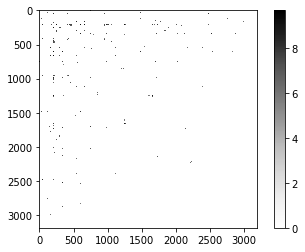

In [23]:
plt.imshow(np.log(weighted_matrix + 1),cmap = 'Greys')
plt.colorbar()

In [24]:
# Plot distribution of inverse distances
values = []

for i in range(n_nodes):
    for j in range(n_nodes):
        if weighted_matrix_inv[i][j] != 0:
            values.append(weighted_matrix_inv[i][j])

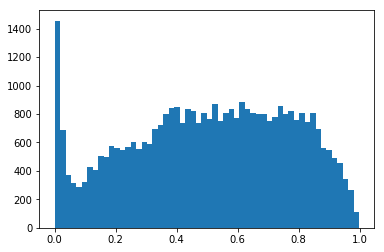

In [25]:
plt.hist(values, bins = int(np.sqrt(n_nodes)));

In [26]:
#ground truth
dic = {"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10,np.nan:10}

labels = nodes.Continent
labels = np.array(labels.replace(dic).tolist())

In [27]:
print([(i, labels.tolist().count(i)) for i in set(labels)])

[(1, 1225), (2, 769), (3, 561), (4, 258), (5, 175), (6, 112), (7, 32), (8, 29), (9, 1), (10, 24)]


### Laplacian eigenmaps tests

In [28]:
#Useless so far for the code

sparse_weighted_matrix = sparse.csr_matrix(weighted_matrix)
laplacian = sparse.csgraph.laplacian(weighted_matrix)

computation =  scipy.linalg.eigh(laplacian)  #Compute orthonormale basis
eigenvectors = computation[1]
eigenvalues =  computation[0]

#Sort to have ordered eigenvalues
idx = eigenvalues.argsort()  
eigenvalues = np.real(eigenvalues[idx])
eigenvectors = np.real(eigenvectors[:,idx])

In [29]:
#inv weighted matrix, Useless so far for the code

laplacian_inv = sparse.csgraph.laplacian(weighted_matrix_inv)

computation_inv =  scipy.linalg.eigh(laplacian_inv)  #Compute orthonormale basis
eigenvectors_inv = computation_inv[1]
eigenvalues_inv =  computation_inv[0]

#Sort to have ordered eigenvalues
idx_inv = eigenvalues_inv.argsort()  
eigenvalues_inv = np.round_(np.real(eigenvalues_inv[idx_inv]), 13)
eigenvectors_inv = np.real(eigenvectors_inv[:,idx_inv])

In [ ]:
#Test with "eigenvectors" L*u = lambda*D*u

laplacian_norm, D = sparse.csgraph.laplacian(weighted_matrix_inv, normed=True, return_diag=True)
D = np.diag(D)

computation_norm =  scipy.linalg.eigh(laplacian_norm)  #Compute orthonormale basis
eigenvectors_norm = computation_norm[1]
eigenvalues_norm =  computation_norm[0]

#Sort to have ordered eigenvalues
idx_norm = eigenvalues_norm.argsort()  
eigenvalues_norm = np.round_(np.real(eigenvalues_norm[idx_norm]), 13)
eigenvectors_norm = np.real(eigenvectors_norm[:,idx_norm])

eigenvectors_u = np.linalg.inv(D)@eigenvectors_norm
eigenvalues_u = eigenvalues_norm

In [ ]:
Y = eigenvectors_u[:, 14:16] #Could be more than 2 eigenvectors

In [ ]:
#Clustering
kmeans = KMeans(n_clusters=20)
kmeans.fit(Y)

In [ ]:
lab = kmeans.labels_

In [ ]:
# dic_color = {0: "BLUE",
#              1: "TEAL",
#              2: "GREEN",
#              3: "YELLOW",
#              4: "RED",
#              5: "FUCHSIA",
#              6: "BLACK",
#              7: "SILVER",
#              8: "OLIVE",
#              9: "ORANGE"
# }

In [ ]:
dic_color = {0: '#e6194b',
             1: '#3cb44b',
             2: '#ffe119',
             3: '#4363d8',
             4: '#f58231',
             5: '#911eb4',
             6: '#46f0f0',
             7: '#f032e6',
             8: '#bcf60c',
             9: '#fabebe',
             10: '#008080',
             11: '#e6beff',
             12: '#9a6324',
             13: '#fffac8',
             14: '#800000',
             15: '#aaffc3',
             16: '#808000',
             17: '#ffd8b1',
             18: '#000075',
             19: '#808080',
             20: '#000000'
}

In [ ]:
lab_color = [dic_color[lab[i]] for i in range(len(lab))]

In [ ]:
#Plot on the first two eigenvectors
plt.scatter(Y[:,0],Y[:,1], c=lab_color, cmap='rainbow')  
plt.show()

In [ ]:
#Creation of the map (called mapit). You can visualize it by opening the file on Internet
mapit = folium.Map(tiles="Mapbox Bright")
j=0

#plot nodes
for i in nodes.iterrows():
    coord = [i[1].Latitude, i[1].Longitude]
    folium.CircleMarker( location=coord, radius=1, color=lab_color[j], fill=True).add_to( mapit )
    j += 1
    
#plot edges
# for i in edges.iloc[:].iterrows():
#     my_edge = [coord[i[1].source_airport_id], coord[i[1].destination_airport_id]]
#     folium.vector_layers.PolyLine(my_edge, color="black", weight=0.5, opacity=0.5).add_to( mapit )
               

In [ ]:
mapit.save('mapit_JB.html')

### Computing the error between ground truth and our prediction

The idea is to compute the percentage of good predictions we can get from our model compared to the ground truth labels i.e how many airports are correclty labelled in percentage.
Correctly labelled means that the cluster in which the airport is attributed is the true continent label of the airport.

The problem is that K-Means produce several clusters randomly : if we compute 10 clusters, we cannot easily associate each one to a continent to compare.
For example : if a cluster is formed on the basis of Europe and Africa, what continent should it be associated to ?

One possible idea is to choose keys of the continents that will represent their clusters. We can say that if we take Paris as the key to Europe, we compare the cluster in which Paris is, and the continent Europe. This method is not flawless, but can serve as a way to begin the experiments on finding a good loss function for our optimization. The aim is to automatize this process which is time-consuming and imprecise.

The continent labels we have are : 
"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10

Keys for the continents :
America =
Asia = 
Europe = Rome
Africa = 
Pacific = 
Australia = 
Atlantic = 
Indian = 
Arctic = 
\N = Agartha TMTC

In [ ]:
# Just for Europe and Roma

Roma_index = []

for i in range(len(airports.City)):
    if (airports.City[i] == "Roma"):
        Roma_index.append(i)

In [ ]:
current_index = Roma_index[0]
latitude_R = airports.Latitude[current_index]
longitude_R = airports.Longitude[current_index]

In [ ]:
# Finding the index of the key in the nodes
key_index = -1
for i in range(n_nodes):
    if ((nodes.Latitude.values[i] == latitude_R) and (nodes.Longitude.values[i] == longitude_R)):
        key_index = i

In [ ]:
label_Europe = lab[key_index]
# We can now compare the airports in the cluster associated with label_Europe

# Percentage of the European airports that are well recognized :
total_eu = 0
score_eu = 0
for i in range(n_nodes):
    if(nodes.Continent.values[i] == "Europe"):
        total_eu+=1
        if(lab[i] == label_Europe):
            score_eu+=1

In [ ]:
sum([1 for i in range(n_nodes) if(lab[i]==label_Europe)])

In [ ]:
score_eu

### Plot graph with networkx

In [ ]:
graph = nx.from_numpy_matrix(weighted_matrix_inv)
coords = nx.spring_layout(graph)

plt.figure(figsize=(10,7))
nc = nx.draw_networkx_nodes(graph, coords, node_size=20, cmap=plt.cm.jet)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Labelled airports");